# Experiment regarding the line finder framework

In [2]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
from src.data.dataset_line_finder import DatasetLineFinder

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
parameters = {"input_folder": '..\\data\\cBAD-ICDAR2019', "max_side": 512, "crop_size": 256}
ds = DatasetLineFinder(inf_type='train', parameters=parameters)

## Plot label

In [4]:
n = 3

In [5]:
data = ds[n]

img = data['image'].numpy().transpose(1,2,0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)

ll = data['label_len']
sp = data['label'][:ll, 0:2]
angles = data['label'][:ll, 2]
box_size = 32

#plt.imshow(img)

In [6]:
labels = np.zeros(img.shape)

for k, s in enumerate(sp):
    x = int(s[0].item())
    y = int(s[1].item())
    cv2.circle(labels, (x, y), box_size, (1.0,0,0), 4)
    cv2.line(labels, (x,y), (x + 2*box_size*np.cos(angles[k]), y - 2*box_size*np.sin(angles[k])), (0, 1.0, 0), 4)
    
    
#plt.imshow(labels)

Some plots that show what the dataset ouputs

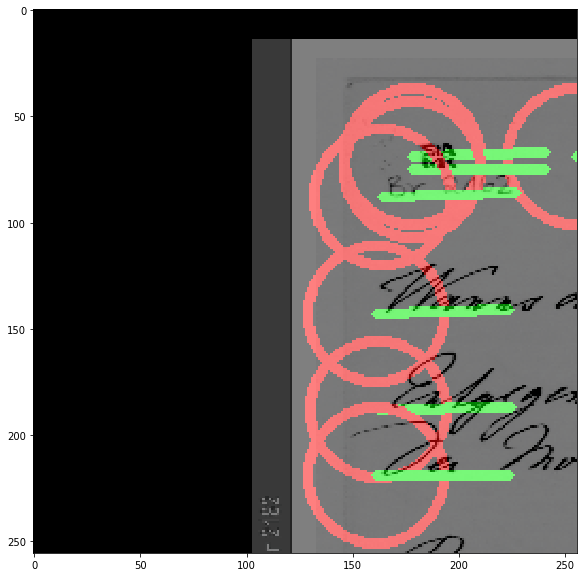

In [7]:
combined = cv2.addWeighted(img, 0.5, labels, 0.5, 0)

plt.figure(figsize=(20,10))
plt.imshow(combined)

## Plot model output

In [8]:
model_ft = torch.load(os.path.join('..', 'trained_models', 'line_finder', 'line_finder_default.pt'), map_location=torch.device('cpu'))
model_ft.device = torch.device('cpu')

In [9]:
n = 3

In [10]:
out = model_ft(data['image'].unsqueeze(0))

In [11]:
out.shape

torch.Size([1, 256, 4])

In [12]:
sp.shape

torch.Size([7, 2])

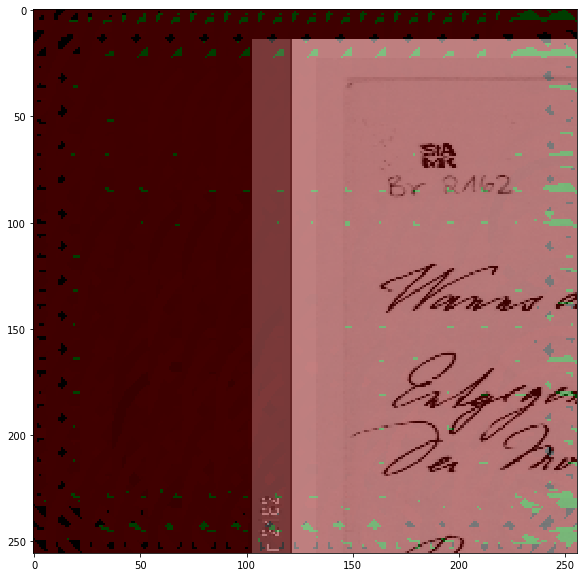

In [13]:
img = data['image'].numpy().transpose(1,2,0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)


sp = out[0, :, 0:2].detach()
angles = out[0, :, 2].detach()
confidence = out[0, :, 3].detach()
box_size = 32

labels = np.zeros(img.shape)

for k, s in enumerate(sp):
    if confidence[k] < -0.1:
        continue
    else:
        ccolor = 1.0*confidence[k].item()
        x = int(s[0].item())
        y = int(s[1].item())
        cv2.circle(labels, (x, y), box_size, (ccolor,0,0), 4)
        cv2.line(labels, (x,y), (x + 2*box_size*np.cos(angles[k]), y - 2*box_size*np.sin(angles[k])), (0, ccolor, 0), 4)
    
combined = cv2.addWeighted(img, 0.5, labels, 0.5, 0)

plt.figure(figsize=(20,10))
plt.imshow(combined)

In [14]:
import torch
import torch.nn as nn
from scipy.optimize import linear_sum_assignment

In [15]:
pred = out
label = data['label'].unsqueeze(0)
label_len = torch.tensor(data['label_len']).unsqueeze(0)

In [43]:
batch_size = pred.shape[0]

#TODO: find better solution
if pred.shape[1] < label.shape[1]:
    label = label[:, 0:pred.shape[1], :]

location_loss = 0
confidence_loss = 0

for b in range(batch_size):
    # If the page is empty punish the model if it finds anything at all:
    if label.shape[1] == 0:
        conf_scores = pred[b, :, -1]
        confidence_loss += -torch.log(1 - conf_scores + 0.01).sum()
    else:
        # I get P predictions and T true labels.
        inp = pred[b, :, 0:3]
        targ = label[b, 0:label_len[b], :]
        inp = targ

        conf_scores = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])#pred[b, :, -1]
        conf_scores = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

        # Compute the confidence for all P predictions.
        log_c = torch.log(conf_scores + 0.00001)
        log_c_anti = torch.log(1 - conf_scores + 0.00001)

        # Expand such that for all T true lables I have a row of all predicted confidence logs.
        # The result is a P x T matrix.
        log_c_exp = log_c[:, None].expand(-1, targ.shape[0])
        log_c_anti_exp = log_c_anti[:, None].expand(-1, targ.shape[0])

        # Expand such that I get P x T x 4 matrices.
        inp_exp = inp[:, None, :].expand(-1, targ.shape[0], -1)
        targ_exp = targ[None, :, :].expand(inp.shape[0], -1, -1)

        # Compute the difference between every pair of prediction and true label locations.
        diff = (inp_exp[:, :, 0:3] - targ_exp[:, :, 0:3])
        normed_diff = torch.norm(diff, 2, 2) ** 2

        # Loss = Sum_{n=0}^N Sum_{m=0}^M    X_nm [alpha*MSE(l_n, p_m) - Log(c_m)] - (1- X_nm) Log(1-c_m)
        # where:
        #   N:      prediction dimension
        #   M:      label dimension
        #   X_mn:   linear assignement matrix
        #   l_n:    label coordinates
        #   p_m:    prediction coordinates
        #   c_m:    confidence scores
        
        # Compute the cost matrix. This is a P x T matrix.
        C = normed_diff/2.0 - log_c_exp + log_c_anti_exp
        C = C.cpu().detach().numpy()

        X = torch.zeros(C.shape)
        x_c = torch.ones(C.shape[0])

        # For every row index (true), compute the column index (pred) where the cost is minimal.
        row_idx, col_idx = linear_sum_assignment(C.T)

        X[(col_idx, row_idx)] = 1.0
        x_c[col_idx] = 0.0

        X = X.to(inp.device)
        x_c = x_c.to(inp.device)

        location_loss += (normed_diff * X).sum()/2.0
        confidence_loss += -(log_c_exp * X).sum() - (log_c_anti * x_c).sum()

# loss = 0.1 * self.alpha * location_loss + confidence_loss
loss = confidence_loss


In [44]:
location_loss

tensor(0.)

In [45]:
confidence_loss

tensor(80.5905)

In [30]:
x_c-(1.0-torch.sum(X, 1))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [19]:
log_c_exp

tensor([[-0.6392, -0.6392, -0.6392,  ..., -0.6392, -0.6392, -0.6392],
        [-0.6805, -0.6805, -0.6805,  ..., -0.6805, -0.6805, -0.6805],
        [-0.6749, -0.6749, -0.6749,  ..., -0.6749, -0.6749, -0.6749],
        ...,
        [-0.6676, -0.6676, -0.6676,  ..., -0.6676, -0.6676, -0.6676],
        [-0.7327, -0.7327, -0.7327,  ..., -0.7327, -0.7327, -0.7327],
        [-0.7238, -0.7238, -0.7238,  ..., -0.7238, -0.7238, -0.7238]],
       grad_fn=<ExpandBackward>)

In [17]:
log_c_anti_exp.shape

torch.Size([256, 7])

In [18]:
log_c_exp.shape

torch.Size([256, 7])

In [154]:
location_loss

tensor(211.5871, grad_fn=<AddBackward0>)

In [155]:
confidence_loss

tensor(175.4001, grad_fn=<AddBackward0>)

In [151]:
inp.shape

torch.Size([256, 3])

In [152]:
targ.shape

torch.Size([7, 3])

In [153]:
row_idx

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [142]:
col_idx

array([244, 180, 164, 165, 168, 171, 173], dtype=int64)

In [143]:
C.T[0,61]

30686.006

In [144]:
min(C.T[1,:])

16.941822

In [145]:
for n, p in enumerate(targ_exp[0]):        
    print('{}: {:.2f},   {:.2f}'.format(n, p[0], p[1]))

0: 255.73,   69.40
1: 178.97,   69.08
2: 178.18,   75.08
3: 164.72,   88.97
4: 161.16,   143.42
5: 162.55,   188.09
6: 161.56,   219.18


In [146]:
for n, p in enumerate(inp_exp[:,0]):        
    print('{}: {:.2f},   {:.2f}'.format(n, p[0], p[1]))

0: 7.85,   8.08
1: 8.06,   24.01
2: 7.98,   39.99
3: 7.98,   56.01
4: 7.95,   71.98
5: 7.98,   88.09
6: 7.95,   104.03
7: 7.96,   119.98
8: 7.93,   135.98
9: 7.91,   151.98
10: 7.94,   167.99
11: 7.97,   183.99
12: 7.95,   199.97
13: 7.94,   215.96
14: 7.84,   231.95
15: 8.00,   248.03
16: 24.08,   7.97
17: 24.12,   24.03
18: 24.07,   40.00
19: 24.09,   55.98
20: 24.10,   71.96
21: 24.12,   87.89
22: 24.06,   103.86
23: 23.96,   119.82
24: 24.02,   135.91
25: 24.03,   152.01
26: 24.03,   168.02
27: 24.03,   184.04
28: 24.03,   200.03
29: 23.99,   215.97
30: 23.94,   231.99
31: 24.03,   247.97
32: 39.98,   7.99
33: 40.09,   23.98
34: 40.06,   40.01
35: 40.09,   56.02
36: 40.05,   72.02
37: 40.11,   87.94
38: 40.03,   103.89
39: 40.09,   120.07
40: 40.01,   135.95
41: 40.11,   151.92
42: 40.13,   168.02
43: 40.18,   184.06
44: 40.14,   200.07
45: 40.13,   216.10
46: 40.05,   232.08
47: 40.10,   247.98
48: 55.94,   7.97
49: 56.06,   23.92
50: 56.04,   40.05
51: 56.07,   56.01
52: 56.03,  

In [133]:
row = 0
column = -1
cnter = 0

for p in inp_exp[:,0]:
    column += 1
    if column == 16:
        row += 1
        column = 0
        
    print('{:.2f},   {:.2f},   {:.2f}'.format(p[0]-row*16-8, p[1]-column*16-8, p[2]))
    

-0.15,   0.08,   0.08
0.06,   0.01,   0.02
-0.02,   -0.01,   0.04
-0.02,   0.01,   0.05
-0.05,   -0.02,   0.04
-0.02,   0.09,   0.01
-0.05,   0.03,   -0.02
-0.04,   -0.02,   0.06
-0.07,   -0.02,   0.04
-0.09,   -0.02,   0.05
-0.06,   -0.01,   0.06
-0.03,   -0.01,   0.06
-0.05,   -0.03,   0.08
-0.06,   -0.04,   0.06
-0.16,   -0.05,   0.06
0.00,   0.03,   0.10
0.08,   -0.03,   0.02
0.12,   0.03,   0.11
0.07,   0.00,   0.09
0.09,   -0.02,   0.05
0.10,   -0.04,   0.09
0.12,   -0.11,   0.05
0.06,   -0.14,   0.01
-0.04,   -0.18,   -0.16
0.02,   -0.09,   -0.11
0.03,   0.01,   -0.06
0.03,   0.02,   -0.02
0.03,   0.04,   0.02
0.03,   0.03,   0.00
-0.01,   -0.03,   -0.01
-0.06,   -0.01,   0.07
0.03,   -0.03,   0.05
-0.02,   -0.01,   0.08
0.09,   -0.02,   0.10
0.06,   0.01,   0.08
0.09,   0.02,   0.03
0.05,   0.02,   0.07
0.11,   -0.06,   0.06
0.03,   -0.11,   0.04
0.09,   0.07,   -0.01
0.01,   -0.05,   -0.03
0.11,   -0.08,   -0.10
0.13,   0.02,   -0.11
0.18,   0.06,   -0.09
0.14,   0.07,   -0.02

In [104]:
inp_exp[0]

tensor([[46.6338, -5.1038,  0.2394],
        [46.6338, -5.1038,  0.2394],
        [46.6338, -5.1038,  0.2394],
        [46.6338, -5.1038,  0.2394],
        [46.6338, -5.1038,  0.2394],
        [46.6338, -5.1038,  0.2394],
        [46.6338, -5.1038,  0.2394]], grad_fn=<SelectBackward>)

In [105]:
targ_exp[0]

tensor([[ 2.5573e+02,  6.9398e+01,  5.1580e-03],
        [ 1.7897e+02,  6.9083e+01,  1.9777e-02],
        [ 1.7818e+02,  7.5080e+01, -1.3078e-02],
        [ 1.6472e+02,  8.8969e+01,  2.7247e-02],
        [ 1.6116e+02,  1.4342e+02,  2.4983e-02],
        [ 1.6255e+02,  1.8809e+02,  1.2087e-02],
        [ 1.6156e+02,  2.1918e+02, -4.7629e-03]])

In [106]:
inp_exp[1]

tensor([[54.0546, -3.3111,  0.0796],
        [54.0546, -3.3111,  0.0796],
        [54.0546, -3.3111,  0.0796],
        [54.0546, -3.3111,  0.0796],
        [54.0546, -3.3111,  0.0796],
        [54.0546, -3.3111,  0.0796],
        [54.0546, -3.3111,  0.0796]], grad_fn=<SelectBackward>)

In [107]:
targ_exp[1]

tensor([[ 2.5573e+02,  6.9398e+01,  5.1580e-03],
        [ 1.7897e+02,  6.9083e+01,  1.9777e-02],
        [ 1.7818e+02,  7.5080e+01, -1.3078e-02],
        [ 1.6472e+02,  8.8969e+01,  2.7247e-02],
        [ 1.6116e+02,  1.4342e+02,  2.4983e-02],
        [ 1.6255e+02,  1.8809e+02,  1.2087e-02],
        [ 1.6156e+02,  2.1918e+02, -4.7629e-03]])

In [128]:
targ_exp.shape

torch.Size([256, 7, 3])

In [129]:
inp_exp.shape

torch.Size([256, 7, 3])

In [100]:
normed_diff.shape

torch.Size([64, 7])

In [23]:
import torch

In [ ]:
from 

In [22]:
torch.load(os.path.join('..', 'trained_models', 'segmentation', 'GCN_512_cBAD.pt'), map_location='cpu')

ModuleNotFoundError: No module named 'src.segmentation'

In [14]:
def draw_start_points(image: torch.tensor, labels: torch.tensor):
    img = image.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    sp = labels[:, 0:2]
    angles = labels[:, 2]
    box_size = labels[:, 3]

    labels_img = np.zeros(img.shape)

    for k, s in enumerate(sp):
        x = int(s[0].item())
        y = int(s[1].item())
        cv2.circle(labels_img, (x, y), box_size[0], (1.0, 0, 0), 4)
        cv2.line(labels_img, (x, y),
                 (x + 2 * box_size[0] * np.cos(angles[k]), y - 2 * box_size[0] * np.sin(angles[k])),
                 (0, 1.0, 0), 4)

    comb = cv2.addWeighted(img, 0.5, labels_img, 0.5, 0)
    comb = torchvision.transforms.ToTensor()(comb).float()

    return comb

In [15]:
import torchvision

c = draw_start_points(ds[0]['image'], ds[0]['label'])
#plt.imshow(c.permute(1,2,0))

IndexError: index 3 is out of bounds for dimension 1 with size 3

In [16]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')

import torch
import numpy as np
import torch.nn as nn
from src.model.line_finder import LineFinder
from src.data.dataset_line_finder import DatasetLineFinder

In [14]:
lf = LineFinder('cpu')

NameError: name 'LineFinder' is not defined

In [15]:
parameters = {"input_folder": '..\\data\\cBAD-ICDAR2019', "max_side": 1000}
ds = DatasetLineFinder(inf_type='train', parameters=parameters)

In [14]:
n = 0

image = ds[n]['image'].unsqueeze(0)
label = ds[n]['label'].unsqueeze(0)

In [15]:
out = lf(image)

In [21]:
from scipy.optimize import linear_sum_assignment

class LineFinderLoss(nn.Module):
    def __init__(self, alpha=0.01):
        super(LineFinderLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.alpha = alpha

    def forward(self, pred, label):
        batch_size = pred.shape[0]
        N = pred.shape[1]
        M = label.shape[1]

        loss = 0

        for b in range(batch_size):
            cost = torch.zeros(N, M)

            for n in range(N):
                for m in range(M):
                    cost[n, m] = self.mse(pred[b, n, 0:2], label[b, m, 0:2])

            
            inp_idx, target_idx = linear_sum_assignment(cost.detach())

        return cost

In [33]:
label

tensor([[[ 1.3908e+02,  8.7815e+01,  6.2364e-03,  5.5256e+01],
         [ 7.0019e+02,  1.1176e+02, -6.0558e-02,  5.5256e+01],
         [ 1.3908e+02,  1.2437e+02,  8.2606e-02,  5.5256e+01],
         [ 1.3426e+02,  1.4118e+02,  5.4093e-02,  5.5256e+01],
         [ 2.6420e+02,  1.5168e+02, -1.6418e-02,  5.5256e+01],
         [ 1.4485e+02,  1.8277e+02, -1.0673e-02,  5.5256e+01],
         [ 1.7372e+02,  2.5588e+02, -6.6311e-03,  5.5256e+01],
         [ 1.7806e+02,  3.0798e+02, -2.9497e-03,  5.5256e+01],
         [ 1.7469e+02,  3.6429e+02, -6.6186e-03,  5.5256e+01],
         [ 1.6891e+02,  4.1765e+02, -3.8731e-03,  5.5256e+01],
         [ 1.6891e+02,  4.6639e+02, -1.1017e-02,  5.5256e+01],
         [ 1.6891e+02,  5.2269e+02, -9.0820e-03,  5.5256e+01],
         [ 1.6651e+02,  5.7605e+02, -1.2172e-02,  5.5256e+01],
         [ 1.6747e+02,  6.2479e+02, -9.9214e-03,  5.5256e+01],
         [ 1.6747e+02,  6.7605e+02, -6.0255e-03,  5.5256e+01],
         [ 1.6987e+02,  7.2941e+02, -8.0735e-03,  5.525

In [35]:
label[0,np.array([1,3,5]),:]

tensor([[ 7.0019e+02,  1.1176e+02, -6.0558e-02,  5.5256e+01],
        [ 1.3426e+02,  1.4118e+02,  5.4093e-02,  5.5256e+01],
        [ 1.4485e+02,  1.8277e+02, -1.0673e-02,  5.5256e+01]])

In [22]:
lossf = LineFinderLoss()

In [23]:
#out.shape

In [24]:
#label.shape

In [25]:
c = lossf(out, label)

torch.Size([1024, 21])


In [44]:
b = c.detach().numpy()

In [ ]:
c = cost_out.detach().numpy()

In [16]:
del c

In [19]:
c = lout.detach().numpy()

In [20]:
linear_sum_assignment(c)

(array([ 30, 103, 104, 105, 107, 108, 111, 112, 113, 114, 116, 117, 120,
        122, 124, 130, 132, 134, 141, 150, 163, 174, 194, 217, 228, 556,
        836], dtype=int64),
 array([26,  7,  8,  9, 10, 11, 15, 16, 17, 18, 19, 20, 22, 24, 25,  1,  0,
         6, 13, 21,  2, 14,  3, 23,  5, 12,  4], dtype=int64))

In [26]:
x = torch.tensor(3.2)

In [27]:
x.detach().numpy()

array(3.2, dtype=float32)

In [29]:
x

tensor(3.2000)

In [ ]:

            print('3')
            cost = cost.detach().numpy()
            inp_idx, target_idx = linear_sum_assignment(cost)
            print('2')
            X = torch.zeros(N, M)
            for p_idx in inp_idx:
                for l_idx in target_idx:
                    X[p_idx, l_idx] = 1
            print('3')
            # Loss = Sum_{n=0}^N Sum_{m=0}^M    X_nm [alpha*MSE(l_n, p_m) - Log(c_m)] - (1- X_nm) Log(1-c_m)
            # where:
            #   N:      prediction dimension
            #   M:      label dimension
            #   X_mn:   linear assignement matrix
            #   l_n:    label coordinates
            #   p_m:    prediction coordinates
            #   c_m:    confidence scores
            for n in range(N):
                for m in range(M):
                    loss += X[n, m]*(self.alpha*self.mse(inp[n, 0:2], target[m, 0:2]) - torch.log(inp[n, 4]))\
                            - (1-X[n, m])*(torch.log(1-inp[n, 4]))
            #loss += nn.MSELoss()(input[:, 3], target[:, 3])
        
        return loss